In [36]:
import warnings
import yaml

from pathlib import Path
from typing import Literal

import s2shores
from s2shores.bathylauncher.products.geotiff_product import GeoTiffProduct
from s2shores.bathylauncher.bathy_launcher import BathyLauncher, BathyEstimator
from s2shores.global_bathymetry.ortho_bathy_estimator import OrthoBathyEstimator
from s2shores.image.ortho_sequence import OrthoSequence
from s2shores.data_model.estimated_points_bathy import EstimatedPointsBathy
from s2shores.local_bathymetry.local_bathy_estimator_factory import local_bathy_estimator_factory
from s2shores.waves_exceptions import WavesException
from s2shores.bathy_debug.spatial_dft_bathy_estimator_debug import SpatialDFTBathyEstimatorDebug

from shapely.geometry import Point

In [37]:
test_case: Literal["7_4", "8_2"] = "8_2"
method: Literal["spatial_corr", "spatial_dft", "temporal_corr"] = "spatial_dft"

base_path = Path("/home/geoffrey/Projets-Linux/CNES/s2shores/TestsS2Shores")

product_path: Path = base_path / "products" / f"SWASH_{test_case}/testcase_{test_case}.tif"
product_type: str = "geotiff"
output_path: Path = base_path / f"output/{method}_SWASH_{test_case}"
config_file: Path = base_path / f"reference_results/debug_pointswash_{method}/wave_bathy_inversion_config.yaml"
debug_file: Path = base_path / f"debug_points/debug_points_SWASH_{test_case}.yaml"
debug_path: Path = base_path / f"debug/{method}_SWASH_{test_case}"
distoshore_file_path: Path = None
delta_times_path: Path = None
roi_file_path: Path = None
limit_to_roi: bool = False
nb_subtiles: int = 1
sequential: bool = True
profiling: bool = False

## Instanciate the different classes and open configs

In [38]:
# BathyLauncher is tied to Dask
bathy_launcher = BathyLauncher(cluster=None, sequential_run=True)


with open(config_file) as file:
    wave_params = yaml.load(file, Loader=yaml.FullLoader)

if 'CHAINS_VERSIONS' not in wave_params.keys():
    wave_params['CHAINS_VERSIONS'] = \
        f's2shores : {s2shores.__version__}'

points_to_compute = [
    Point(500., 450.),
]


/home/geoffrey/miniconda3/envs/s2shores_env/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43255 instead
  warnings.warn(


In [39]:
# BathyLauncher.launch

# Add product and get its bathy estimator
outputmode = wave_params['GLOBAL_ESTIMATOR']['OUTPUT_FORMAT']

bathy_estimator = bathy_launcher.add_product(
    product_path.stem,
    product_path,
    GeoTiffProduct,
    output_path,
    wave_params,
    nb_subtiles,
)


bathy_estimator.set_gravity_provider(provider_info=None)
bathy_estimator.set_distoshore_provider(provider_info=distoshore_file_path)
bathy_estimator.set_delta_time_provider(provider_info=delta_times_path)
bathy_estimator.set_roi_provider(provider_info=roi_file_path, limit_to_roi=limit_to_roi)

bathy_estimator.create_subtiles()

bathy_estimator.set_debug_samples(points_to_compute)
bathy_estimator.debug_path = debug_path

In [40]:
# BathyLauncher.run
# BathyEstimator.compute_bathy_for_subtile (1)

subtile = bathy_estimator.subtiles[0]
subtile_estimator = OrthoBathyEstimator(bathy_estimator, subtile)

In [41]:
# OrthoBathyEstimator.compute_bathy() (1)

# nbkeep shall be understood as a filtering in terms of the number of proposed samples.
# Will disappear when true Wave Fields will be identified and implemented.
nb_keep = subtile_estimator.parent_estimator.nb_max_wave_fields

# subtile reading
sub_tile_images = OrthoSequence(subtile_estimator.parent_estimator.delta_time_provider)
for frame_id in subtile_estimator.parent_estimator.selected_frames:
    sub_tile_images.append_image(subtile_estimator.sampled_ortho.read_frame_image(frame_id), frame_id)

# Estimate bathy on points
estimated_bathy = EstimatedPointsBathy(
    len(subtile_estimator.parent_estimator._debug_samples),
    subtile_estimator.sampled_ortho.ortho_stack.acquisition_time,
)
estimation_point = subtile_estimator.parent_estimator._debug_samples[0]

In [42]:
# OrthoBathyEstimator._run_local_bathy_estimator

subtile_estimator.parent_estimator.set_debug_flag(estimation_point)

# Build the images sequence for the estimation point
window = subtile_estimator.sampled_ortho.window_extent(estimation_point)
ortho_sequence = sub_tile_images.extract_window(window)
if subtile_estimator.parent_estimator.debug_sample:
    for index, image_sequence in enumerate(ortho_sequence):
        print(f'Subtile shape {sub_tile_images[index].pixels.shape}')
        print(f'Window inside ortho image coordinates: {window}')
        print(f'--{ortho_sequence._images_id[index]} imagette {image_sequence}')

# TODO: use selected_directions argument
local_bathy_estimator = SpatialDFTBathyEstimatorDebug(
    estimation_point,
    ortho_sequence,
    bathy_estimator,
)

bathy_estimations = local_bathy_estimator.bathymetry_estimations
if not local_bathy_estimator.can_estimate_bathy():
    print("Cannot estimate bathy")

Subtile shape (451, 2051)
Window inside ortho image coordinates: (275, 475, 150, 350)
--10 imagette Resolution: 2.0  Shape: (176, 201):
[[-1.5270554  -1.583606   -1.6066728  ... -0.62787575 -0.56006205
  -0.48764074]
 [-1.5270312  -1.5835757  -1.6066395  ... -0.6278751  -0.5600655
  -0.48764995]
 [-1.5270239  -1.5835633  -1.606622   ... -0.6278827  -0.5600737
  -0.4876575 ]
 ...
 [-1.5268911  -1.5834917  -1.6066017  ... -0.6272342  -0.5594998
  -0.48718882]
 [-1.5269201  -1.5835073  -1.6066042  ... -0.6272627  -0.55951333
  -0.48718292]
 [-1.5269682  -1.5835388  -1.6066175  ... -0.6273064  -0.55954146
  -0.4871913 ]]
Subtile shape (451, 2051)
Window inside ortho image coordinates: (275, 475, 150, 350)
--13 imagette Resolution: 2.0  Shape: (176, 201):
[[1.6179782  1.5509957  1.4425867  ... 0.9189765  0.7568105  0.5947771 ]
 [1.6179675  1.5509801  1.4425625  ... 0.91895694 0.7567914  0.5947569 ]
 [1.6179689  1.5509802  1.4425572  ... 0.918941   0.7567738  0.5947318 ]
 ...
 [1.6179767  1.

initial peaks:  [180]
peaks_pairs:  []
peaks kept from peaks_pairs:  []
final peaks after adding isolated peaks:  [180]
input pixels for Radon transform 1  (176, 201) float64
[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]
Radon transform 1 (176, 360) float64
[[-2.11790780e-01 -2.80883980e-01 -3.27769153e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.36571452e+00 -8.54476484e-01 -4.04607114e-01 ... -3.53964335e-01
  -3.27403751e-01 -2.80680196e-01]
 [ 4.74344263e+00  5.21067670e+00  5.47611135e+00 ...  6.39479718e-03
  -4.04271536e-01 -8.54337916e-01]
 ...
 [ 1.61481878e+01  1.64228047e+01  1.64910253e+01 ...  2.45159591e+01
   2.44017832e+01  2.46426902e+01]
 [ 8.57829194e+00  8.83195036e+00  8.90600242e+00 ...  1.69394743e+01
   1.64903948e+01  1.64224827e+01]
 [ 2.42595750e+00  2.77594882e+00  3.01354153e+00 ...  9.11655055e

/home/geoffrey/Projets-Linux/CNES/s2shores/src/s2shores/bathy_debug/spatial_dft_wave_fields_display.py:187: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


ARROWS [(0.0, 277716945.01405776)]
-->ARROW SIGNING THE MAX ENERGY [DFN, ENERGY, WAVELENGTH]]= (270.0, 277716945.01405776, 137.53546294990986)
MAIN DIRECTION 0.0
DIRECTION FROM NORTH 270.0
DELTA TIME 3.0
DELTA PHASE 2.06536271120025


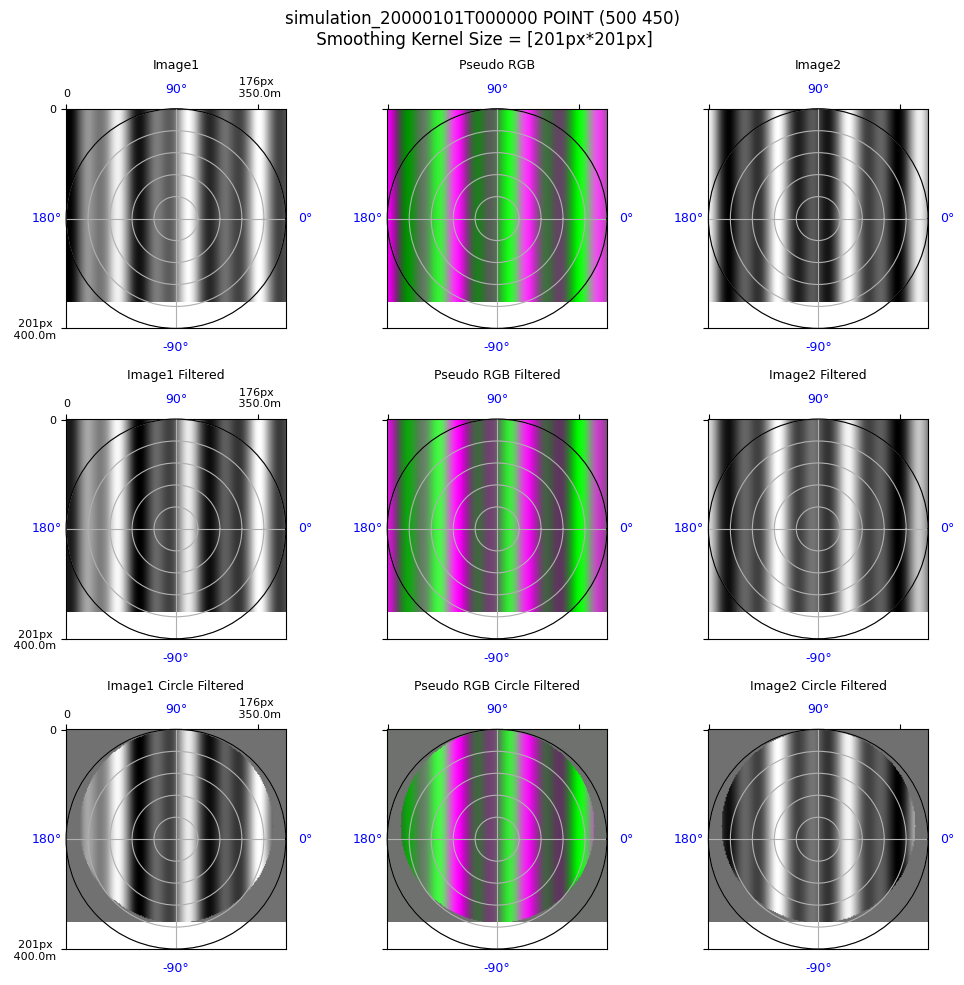

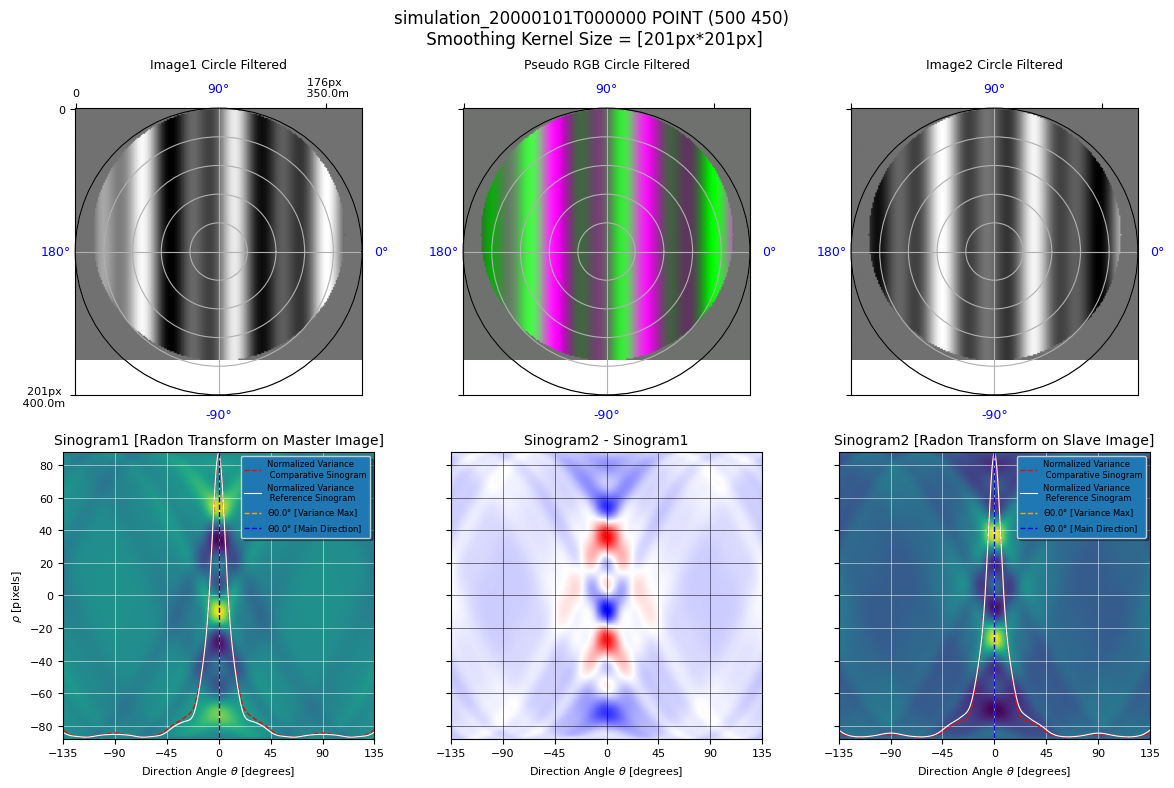

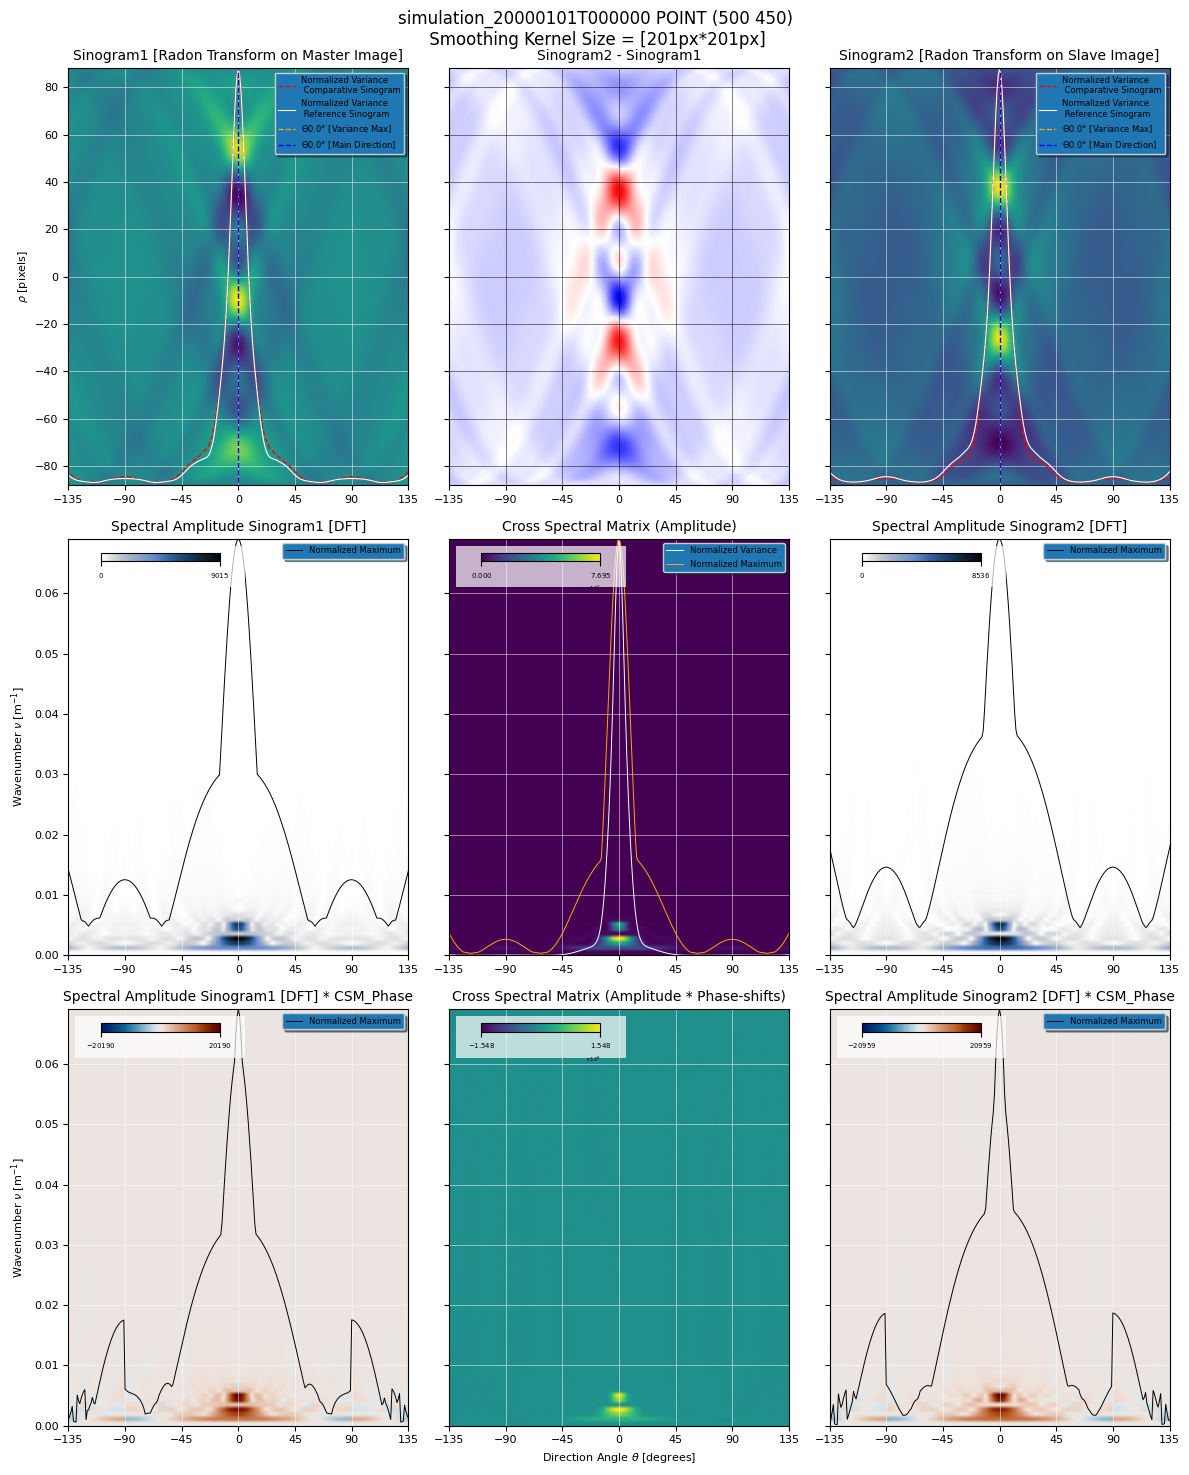

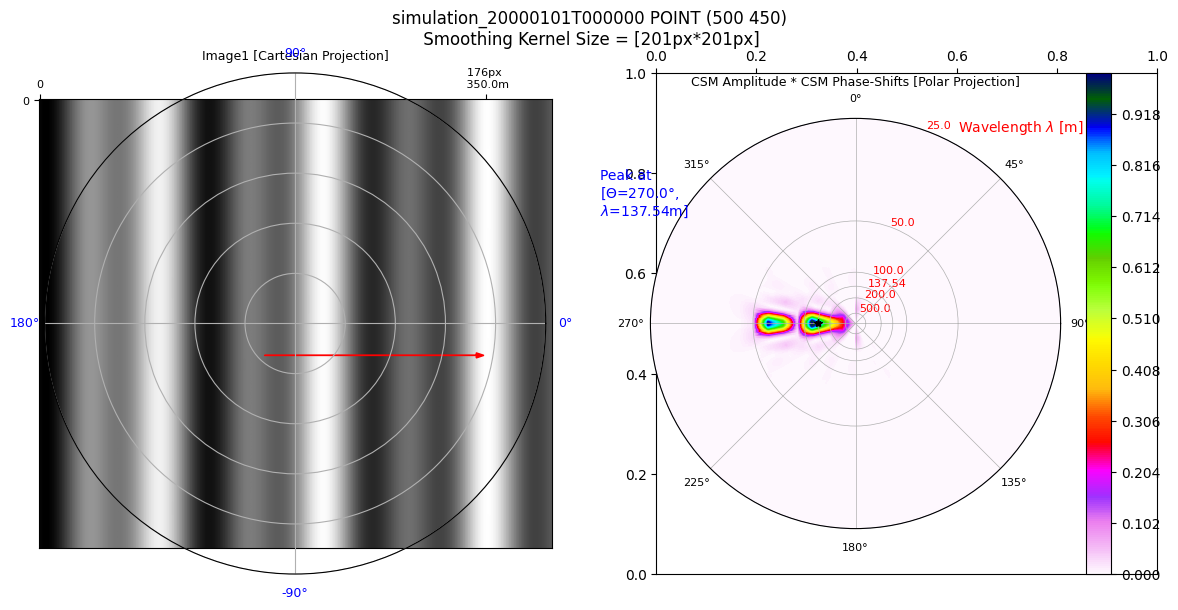

In [45]:
# LocalBathyEstimator.run()

local_bathy_estimator.preprocess_images()

local_bathy_estimator.compute_radon_transforms()

peaks_dir_indices = local_bathy_estimator.find_directions()

directions_ranges = local_bathy_estimator.prepare_refinement(peaks_dir_indices)

local_bathy_estimator.find_spectral_peaks(directions_ranges)

local_bathy_estimator.explore_results()

In [46]:
bathy_estimations.remove_unphysical_wave_fields()
bathy_estimations.sort_on_attribute(local_bathy_estimator.final_estimations_sorting)
if subtile_estimator.parent_estimator.debug_sample:
    print('estimations after sorting :')
    print(bathy_estimations)

estimations after sorting :
+++++++++ Set of estimations made at: POINT (500 450) 
  distance to shore: inf   gravity: 9.78000000026094
  availability:  (data: True, delta time: True)
  STATUS: 1 (0: SUCCESS, 1: FAIL, 2: ON_GROUND, 3: NO_DATA, 4: NO_DELTA_TIME, 5: OUTSIDE_ROI, 6: BEYOND_OFFSHORE_LIMIT)
0 estimations available:



In [47]:
# OrthoBathyEstimator.compute_bathy() (2)


estimated_bathy.store_estimations(0, bathy_estimations)
dataset = estimated_bathy.build_dataset(subtile_estimator.parent_estimator.layers_type, nb_keep)

In [48]:
# BathyEstimator.compute_bathy_for_subtile (2)


# Build the bathymetry dataset for the subtile.
# Add spatial_ref variable to the Dataset
dataset = dataset.assign({'spatial_ref': 0})
# Assign relevant projection attribute of the spatial_ref variable
dataset.spatial_ref.attrs['spatial_ref'] = bathy_estimator._ortho_stack.build_spatial_ref()

# necessary to have a correct georeferencing
if 'x' in dataset.coords:  # only if output_format is GRID
    dataset.x.attrs['standard_name'] = 'projection_x_coordinate'
    dataset.y.attrs['standard_name'] = 'projection_y_coordinate'

infos = bathy_estimator.build_infos()
infos.update(bathy_estimator._ortho_stack.build_infos())
for key, value in infos.items():
    dataset.attrs[key] = value

In [52]:
# BathyEstimator.merge_subtiles
import xarray as xr

merged_bathy = xr.combine_by_coords([dataset])
merged_bathy

<xarray.Dataset> Size: 46B
Dimensions:                 (time: 1, index: 1)
Coordinates:
  * time                    (time) datetime64[ns] 8B 2000-01-01
  * index                   (index) int64 8B 1
Data variables:
    Status                  (time, index) uint16 2B 1
    Distoshore              (time, index) float32 4B inf
    Gravity                 (time, index) float32 4B 9.78
    Delta Acquisition Time  (time, index) float32 4B 3.0
    X                       (time, index) float32 4B 500.0
    Y                       (time, index) float32 4B 450.0
    spatial_ref             int64 8B 0
Attributes: (12/15)
    title:                 Wave parameters and raw bathymetry derived from sa...
    institution:           CNES-LEGOS
    coordinates:           spatial_ref
    waveEstimationMethod:  SPATIAL_DFT
    ChainVersions:         s2shores : 1.0.0
    Resolution X:          50.0
    ...                    ...
    Proc_level:            SENSOR
    Proc_baseline:         NONE
    Rel_Orbit:             NONE
    sat:                   swash
    AcquisitionTime:       20000101T000000
    epsg:                  EPSG:32632